# Basic imports

In [ ]:
import re
import pdfplumber
from spacy.lang.nb import Norwegian
import spacy

# Helper functions

In [ ]:
def pdfToText(fileName):
    all_text = ""
    with pdfplumber.open(fileName) as pdf:
        for page in pdf.pages:
            all_text += page.extract_text()
    # print(all_text)
    all_text = re.sub('\s', ' ', all_text)
    # print(all_text)
    return all_text

regPlan = pdfToText('regional-planstrategi-2016-2010.pdf')
kirkepol = pdfToText('050200-sak-kommunens-kirkepolitikk.pdf')
smabathavn = pdfToText('kommunedelplan-for-smabathavner-2007-2017.pdf')
kultur = pdfToText('strategiplan-kultur-web.pdf')
havbruk = pdfToText("havbruk.pdf")

In [ ]:
def txtToStr(filename):
    f = open(filename, 'r')
    textLines = f.readlines()
    text = ""
    for line in textLines:
        text += line
    text = re.sub('\s', ' ', text)
    return text

brautTxt = txtToStr("braut.txt")
byplanWiki = txtToStr("byplanleggingWiki.txt")

# Scraping

No need to run if "sdg#.txt" in "sdgs" folder is present.

In [ ]:
# Scraping imports and inits
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install())
from bs4 import BeautifulSoup as BS

In [ ]:
# Scraping sdgs from FN.
sdgs = []
driver.get("https://www.fn.no/om-fn/fns-baerekraftsmaal")
soup = BS(driver.page_source, features="html.parser")
title_cards = soup.find_all(class_="header_gols_content_item")
for card in title_cards:
    a = card.find("a", href=True)
    sdgs.append(a["href"])
print(sdgs)
i = 1
for sdg in sdgs:
    driver.get(f"https://www.fn.no/{sdg}")
    soup = BS(driver.page_source, features="html.parser")
    paragraphs = soup.find_all("p")
    f = open(f'sdgs/sdg{i}.txt', 'w')
    for par in paragraphs:
        line = par.text.strip()
        line = line.replace('...', '')
        line = line.replace('&aelig;', 'æ')
        if len(line) > 0:
            if not line[-1] in ".?!:)":
                line += '.'
            f.write(f'{line}\n')
    f.close()
    i += 1

# Predicting

In [ ]:
def similarityText(mainStr, searchStr):
    """
    Return spacy similatiry based on vector in nb_core_news_lg.
    """
    nlp = spacy.load("nb_core_news_lg")

    mainDoc = nlp(mainStr)
    searchDoc = nlp(searchStr)

    mainTokenized = nlp(' '.join([str(token.lemma_) for token in mainDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    searchTokenized = nlp(' '.join([str(token.lemma_) for token in searchDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    # print(mainTokenized)
    # print(searchTokenized)
    return mainTokenized.similarity(searchTokenized)

In [ ]:
def sdgSimilatiry(string):
    """
    Print and return similarity of string to all SDGs.
    """
    valueList = []
    for sdg in range(17):
        value = similarityText(string, txtToStr(f"sdgs/sdg{sdg+1}.txt"))
        print(f"SDG #{sdg+1} has this similarity to your string: {value}")
        valueList.append(value)
    return valueList

In [ ]:
def addSdgVector(str, name):
    """
    Add similarity results to sdgVector.
    """
    return sdgSimilatiry(str)

In [ ]:
# for documentation see: https://www.kaggle.com/satishgunjal/tutorial-text-classification-using-spacy
import string
nlp = spacy.load("nb_core_news_lg")
parser = Norwegian()
punctuations = string.punctuation
stop_words = spacy.lang.nb.stop_words.STOP_WORDS
def spacy_tokenizer(sentence):
    """This function will accepts a sentence as input and processes the sentence into tokens, performing lemmatization, 
    lowercasing, removing stop words and punctuations."""
    
    # Creating our token object which is used to create documents with linguistic annotations
    mytokens = nlp(sentence)
    
    # lemmatizing each token and converting each token in lower case
    # Note that spaCy uses '-PRON-' as lemma for all personal pronouns lkike me, I etc
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    # Return preprocessed list of tokens
    return mytokens  

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        """Override the transform method to clean text"""
        return [clean_text(text) for text in X]
    
    def fit(self, X, y= None, **fit_params):
        return self
    
    def get_params(self, deep= True):
        return {}

# Basic function to clean the text
def clean_text(text):
    """Removing spaces and converting the text into lowercase"""
    return text.strip().lower()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Creating trainingdata for classifying SDGs
X_train = []
y_train = []
for i in range(17):
    f = open(f'sdgs/sdg{i+1}.txt')
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train.append(line)
        y_train.append(i+1)

In [ ]:
from sklearn.linear_model import LogisticRegression                 

In [ ]:
X_test = [kirkepol, regPlan, kultur, havbruk]

In [ ]:
def tfidfModel(trainingData, testData):
    """
    Return predicted probabilities for Pipeline (pipe).
    """
    # Create pipeline using Tf-idf
    pipe = Pipeline ([("cleaner", predictors()),
                 ("vectorizer", tfidfVector),
                 ("classifier", LogisticRegression(multi_class='ovr', solver='liblinear'))])

    pipe.fit(trainingData[0], trainingData[1])

    predicted = pipe.predict_proba(testData)
    return predicted

# Wiki

In [ ]:
import wikiscraper as ws

In [ ]:
ws.lang("no")

In [ ]:
abstractList = []
with open("randWiki.txt", "a") as file:
    for i in range(1000):
        result = ws.searchBySlug("Spesial:Tilfeldig")
        try:
            abstractList = result.getAbstract()
            for par in abstractList:
                if not "[rediger | rediger kilde]" in par:
                    file.write(par + "\n")
        except:
            pass

# NLP2

In [ ]:
X_train2 = []
y_train2 = []
for i in range(17):
    with open(f'sdgs/sdg{i+1}.txt', 'r') as f:
        for line in f:
            line = re.sub('\s', ' ', line)
            X_train2.append(line)
            y_train2.append(0)

with open('randWiki.txt', 'r') as f:
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train2.append(line)
        y_train2.append(1)


In [ ]:
baerBool = tfidfModel([X_train2, y_train2], X_test)
sdgPredictions = tfidfModel([X_train, y_train], X_test)

In [ ]:
sdgPredictionsMult = sdgPredictions*17
# print(sdgPredictionsMult)

In [ ]:
for i in range(len(sdgPredictionsMult)):
    sdgPredictionsMult[i] = sdgPredictionsMult[i]*baerBool[i][0]
# print(sdgPredictionsMult)
    

In [ ]:
import matplotlib.pyplot as plt

def sdgList(predictions, threshold):
    sdgTrue = 17*[0]
    for i in range(17):
        if predictions[i] > 1:
            sdgTrue[i] = 1
        elif predictions[i] - threshold > 0:
            sdgTrue[i] = (predictions[i] - threshold) / (1 - threshold)
        else:
            sdgTrue[i] = 0
    return sdgTrue
sdgNames = []
for i in range(17):
    sdgNames.append(i+1)
for doku in sdgPredictionsMult:
    print(sdgList(doku, 0.8))
    plt.figure()
    plt.ylim([0,1])
    plt.bar(sdgNames, sdgList(doku, 0.8), 0.7)
    plt.xticks(sdgNames)
    plt.show()


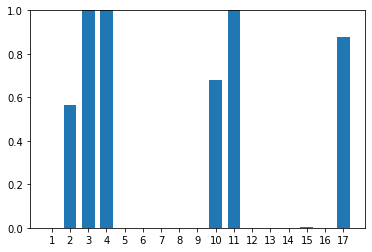

In [133]:
def plotTestTextPredictions(testText):
    barekraftBool = tfidfModel([X_train2, y_train2], testText)
    sdgPredictions = tfidfModel([X_train, y_train], testText)
    sdgPredictionsMult = sdgPredictions*17
    for i in range(len(sdgPredictionsMult)):
        sdgPredictionsMult[i] = sdgPredictionsMult[i] * barekraftBool[i][0]
    sdgNames = []
    for i in range(17):
        sdgNames.append(i+1)
    for doku in sdgPredictionsMult:
        # print(sdgList(doku, 0.8))
        plt.figure()
        plt.ylim([0,1])
        plt.bar(sdgNames, sdgList(doku, 0.8), 0.7)
        plt.xticks(sdgNames)
        plt.show()

psykiskHelse = pdfToText("pdfs/psykiskhelseogrusplan.pdf")
plotTestTextPredictions([psykiskHelse])

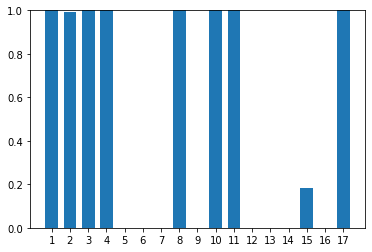

In [134]:
fattigdomGammel = pdfToText("pdfs/temaplan-for-arbeid-mot-fattigdom.pdf")
plotTestTextPredictions([fattigdomGammel])

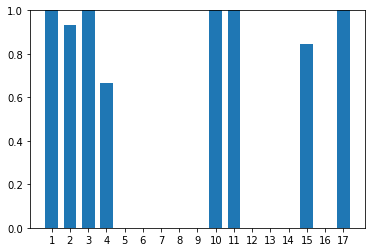

In [136]:
kvalKlubb = pdfToText("pdfs/bettinak,+{$userGroup},+R-18-2-SAM.pdf")
plotTestTextPredictions([kvalKlubb])